### Measuring linear distance with a SmartPhone ###
Using the accelerometer feature of the Physics Toolbox Sensor Suite (free), we record acceleration in a straight line displacement, numerically integrate twice and review velocity and position data.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

### Load Raw Data ###

In [4]:
#df = pd.read_csv("Data/2025-06-3013.43.00.csv")
df = pd.read_csv("Data/2025-07-0811.18.57.csv")
df.head()

,time,ax (m/s^2),ay (m/s^2),az (m/s^2),aT (m/s^2)
0,0.006494,0.0012,-0.0004,-0.0486,0.049
1,0.007284,-0.0038,0.0002,-0.0390,0.039
2,0.024191,-0.0039,-0.0046,-0.0486,0.049
3,0.040632,0.0057,0.0002,-0.0438,0.044
4,0.057899,0.0057,0.0002,-0.0486,0.049


### Visualize the Data ###

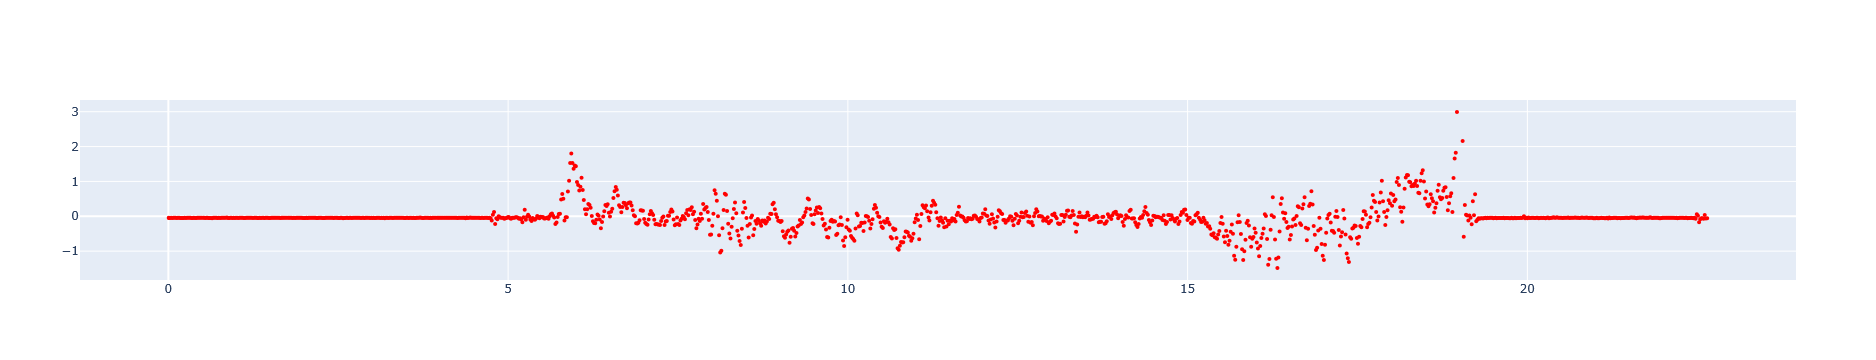

In [19]:
# raw acceleration data in the z direction
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'], y = df['az (m/s^2)'], mode='markers', showlegend=False, marker=dict(color='red', size=4)))
fig.show()

### Compute the Sample Rate ###
What is the time between acceleration measurements?

In [10]:
# compute the average dt using diff() function
df['dt'] = df['time'].diff()
dt = df['dt'].mean()
print("Avg time interval: ", dt)
print("Samples per second: ", 1/dt)

Avg time interval:  0.01677040222222222
Samples per second:  59.62886201232039


### Numerical Integration ###
Let $(t_i,a_i)$ be the $i$th accelerometer measurement $a_i$ at time $t_i$. Let $\Delta t_i = t_i-t_{i-1}\approx dt$. The velocity function is approximated as $$v(t) = \int_0^t a(u)\,du \approx \Sigma_{i=1}^{N} a_i \Delta t_i \approx \Sigma_{i=1}^{N} a_i dt$$ where $t\in (t_{N-1}, t_N]$. Similarly, the position function is approximated as $$p(t) = \int_0^t v(u)\,du \approx \Sigma_{j=1}^{N} v_j \Delta t_j \approx \Sigma_{j=1}^{N} v_j dt$$ where $t\in (t_{N-1}, t_N]$ and $v_j = \Sigma_{i=1}^{j} a_i dt$.

The `.cumsum()` function accepts a column of numbers and generates a new column of numbers that are the cumulative sum of the input column.

In [23]:
# In this experiment, the relevant acceleration data is in the z direction, the direction coming out of the face of the phone.
df['v_z']=df['az (m/s^2)'].cumsum()*dt
df['p_z']=df['v_z'].cumsum()*dt
df.head()

,time,ax (m/s^2),ay (m/s^2),az (m/s^2),aT (m/s^2),dt,v_z,p_z
0,0.006494,0.0012,-0.0004,-0.0486,0.049,NaN,-0.000815,-0.000014
1,0.007284,-0.0038,0.0002,-0.0390,0.039,0.000790,-0.001469,-0.000038
2,0.024191,-0.0039,-0.0046,-0.0486,0.049,0.016907,-0.002284,-0.000077
3,0.040632,0.0057,0.0002,-0.0438,0.044,0.016441,-0.003019,-0.000127
4,0.057899,0.0057,0.0002,-0.0486,0.049,0.017267,-0.003834,-0.000192


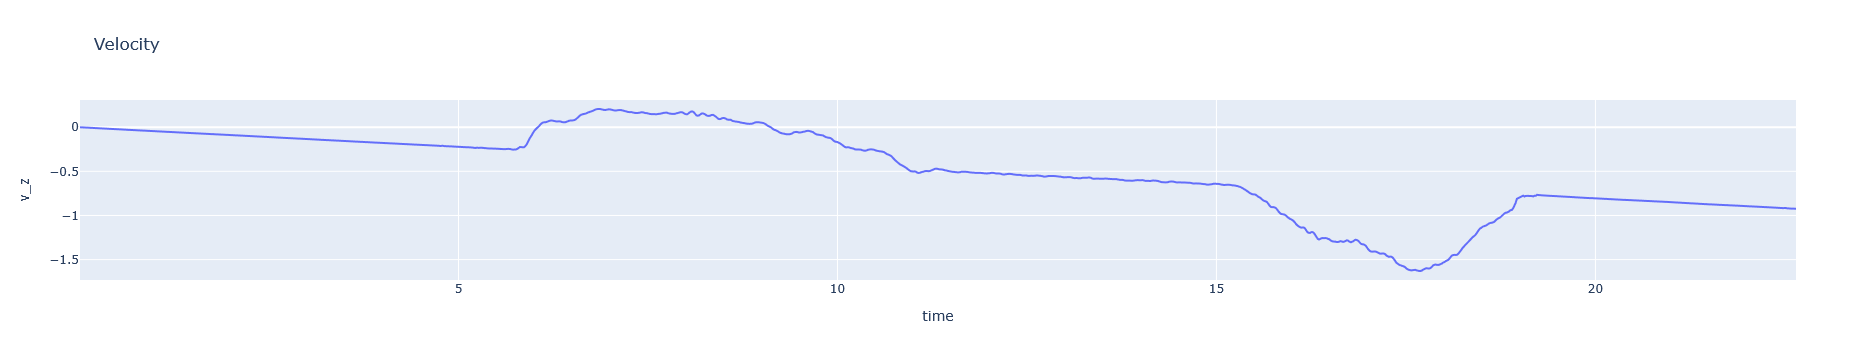

In [25]:
# velocity data
px.line(df,x='time',y='v_z', title="Velocity").show()

### Baseline Shift ###
Often the accelerometer is not correctly "zeroed". A slight postive or negative offset can introduce a positive or negatively sloped linear skew in the velocity. Use the quiet period before the measurement to compute and remove this offset.

In [13]:
# compute the average offset in the first few seconds, observe the sign of the offset
baseline_shift = df[df['time']<5]['az (m/s^2)'].mean()
print("Accelerometer offset: ", baseline_shift)
# zero out the offset in the data
df['az (m/s^2) shifted']=df['az (m/s^2)']-baseline_shift

Accelerometer offset:  -0.044228666666666666


In [14]:
# redo the numerical integration using the corrected data
df['v_z shifted'] = df['az (m/s^2) shifted'].cumsum() * dt
df['p_z shifted'] = df['v_z shifted'].cumsum() * dt

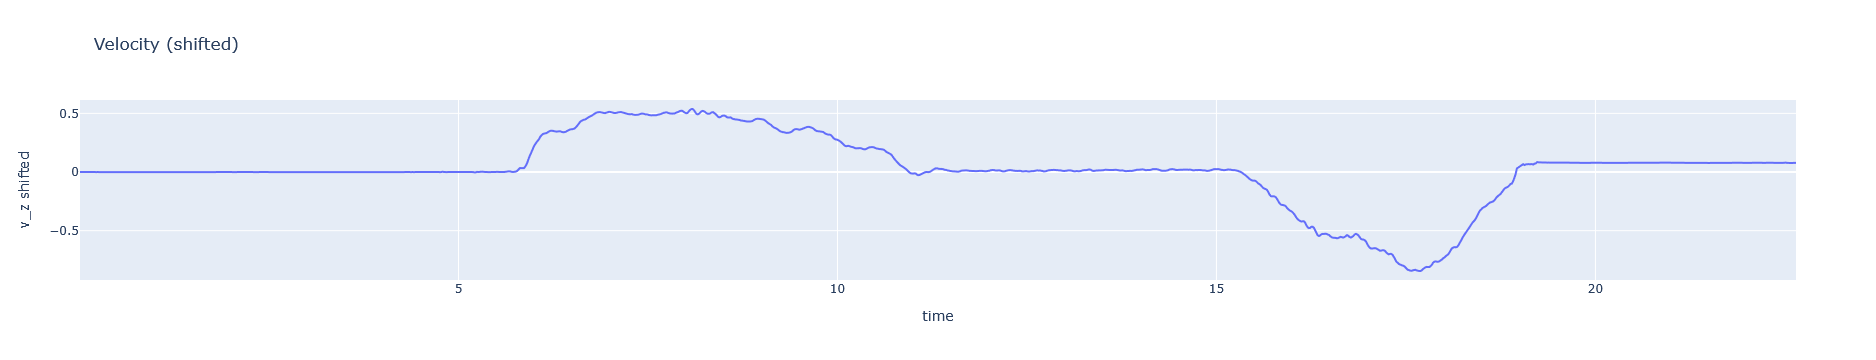

In [15]:
# plot the velocity data, observe reduction in linear skew
px.line(df,x='time',y='v_z shifted', title="Velocity (shifted)").show()

### Plot Position, Estimate Height ###
Observe that some baseline shifting might be occurring. Effect on estimated height?

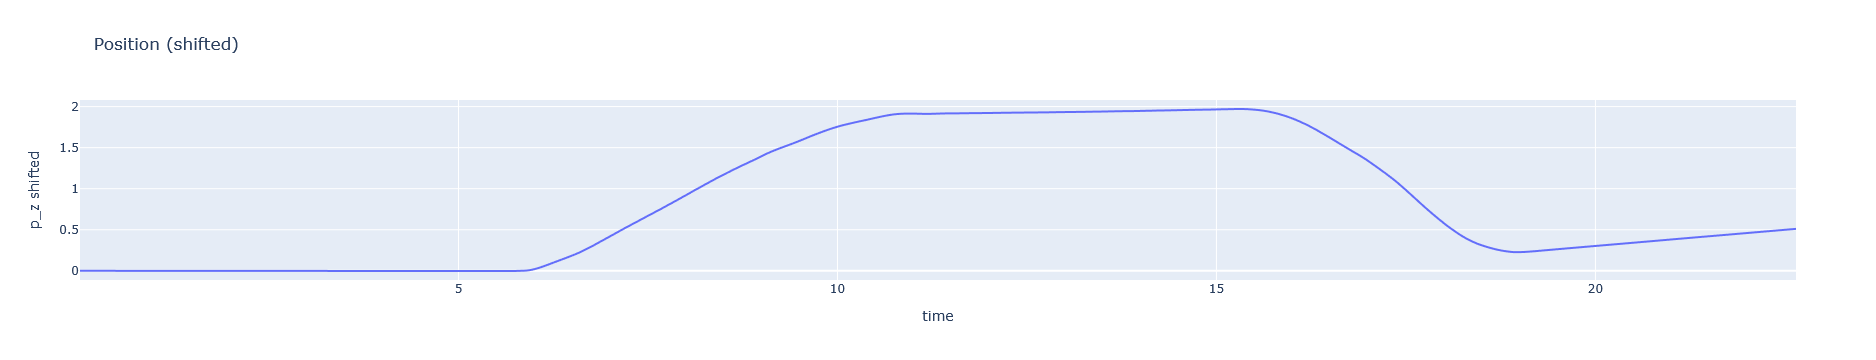

In [17]:
# plot the velocity data, observe reduction in linear skew
px.line(df,x='time',y='p_z shifted', title="Position (shifted)").show()

### From Data to Integrals ###


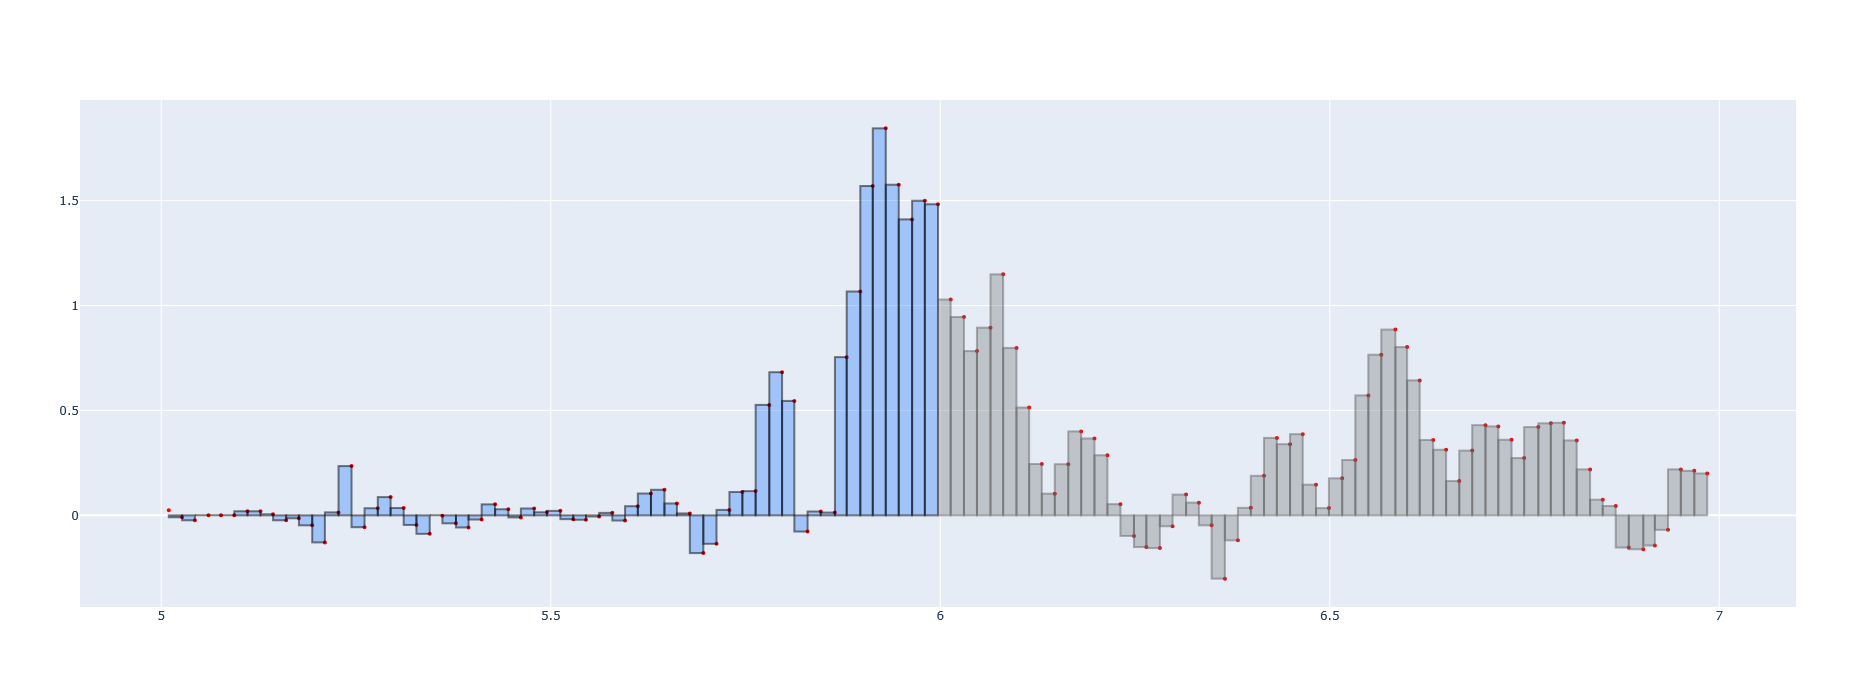

In [35]:
# smaller slice of time
df_slice = df[(df['time']>5) & (df['time']<7)]
time = df_slice['time'].values
accel = df_slice['az (m/s^2) shifted'].values
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y = accel, mode='markers',showlegend=False, marker=dict(color='red', size=4)))
#fig.show()

# add rectangles, e.g. Riemann sum, right endpoint approximation
for i in range(1,len(time)):
    t1 = time[i]
    t0 = time[i-1]
    a = accel[i]
    rect_t = [t0,t1,t1,t0,t0]
    rect_a = [0,0,a,a,0]
    if t1<6:
        fig.add_trace(go.Scatter(x=rect_t,y=rect_a,fill='toself',fillcolor='rgba(0, 100, 255, 0.3)',mode='lines',line=dict(color='rgba(0,0,0,0.5)'),
        showlegend=False))
    else:
        fig.add_trace(go.Scatter(x=rect_t,y=rect_a,fill='toself',fillcolor='rgba(100, 100, 100, 0.3)',mode='lines',line=dict(color='rgba(100,100,100,0.5)'),
        showlegend=False))
# Set figure size (in pixels)
fig.update_layout(
    width=1100,
    height=687
)
fig.show()
    